<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining (QBUS6810)</h1>
<h2 align="center" style="margin-top:10px">Tutorial 3: Regression modelling</h2>
<br>


In this tutorial we will put the linear regression modelling tools from Lecture 2 into practice.

<a href="#Data">Data</a> <br>
<a href="#Training-and-Test-Sets">Training and Test Sets</a> <br>
<a href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#Data-Preparation">Data Preparation</a> <br>
<a href="#Linear-Regression">Linear Regression</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following imports and settings throughout. We will load new packages and functions in context to make clear what we are using them for. 

<hr style="height:2px;border-width:0;color:black;background-color:black">

### A Warning When Modeling
In the real world, if you are not careful with the input variables you use, you can get into real trouble.

When you do life modeling (modeling when people will die) for insurance reasons, it is a rule that you cannot use one's gender nor their ethnicity as modeling predictors. Eventhough these predictors may have high correlation with their life expectancy, it is a big no-no because 

    He missed the point. In mathematics and science, there is no difference in the intelligence of men and women. The difference in genes between men and women is simply the Y chromosome, which has nothing to do with intelligence.
    - Dr Christiane Nüsslein-Volhard, the 1995 Nobel laureate in physiology and medicine
    
In the same sense, when we are trying to model one's salary we should be very careful in what we want our model to do. If we simply want to use our model to observe casual relationships (think correlation), then using these no-no predictors can be okay. But, if we are trying to use the model to make predictions on future data, or make causal inferences (think causation) then it is highly inappropriate to use these predictors.

Taken from [The Most Dangerous Equation](https://www.americanscientist.org/article/the-most-dangerous-equation#:~:text=The%20obvious%20winner%20in%20this,the%20construction%20of%20atomic%20bombs) by Howard Wainer:

    The familiar linear regression equation contains many pitfalls to trap the unwary. The correlation coefficient that emerges from regression tells us about the strength of the linear relation between the dependent and independent variables. But alas it encourages fallacious attributions of cause and effect. It even encourages fallacious interpretation by those who think they are being careful. ("I may not be able to believe the exact value of the coefficient, but surely I can use its sign to tell whether increasing the variable will increase or decrease the answer.") The linear regression equation is also badly non-robust, but its weaknesses are rarely diagnosed appropriately, so many models are misleading. When regression is applied to observational data (as it almost always is), it is difficult to know whether an appropriate set of predictors has been selected—and if we have an inappropriate set, our interpretations are questionable. It is dangerous, ironically, because it can be the most useful model for the widest variety of data when wielded with caution, wisdom and much interaction between the analyst and the computer program.
    - Howard Wainer, The Most Dangerous Equation
  
  
For this class, we are usually not that careful with using taboo predictors. The main reason being that we are not trying to make statements about the world. Perhaps this is me being naive, but out main focus is for the students to understand the different models that will be taught in this course. The easiest way to do so is by building them, which is what we will do in this course.

<hr style="height:2px;border-width:0;color:black;background-color:red">

In [1]:
# Packages
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # this is to clear the warnings from this page, typically you would leave them on

In [40]:
# Plot settings
sns.set_context('notebook') # optimise figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

## Data

The <TT>Employees.csv</TT> file records data about the employees of a company. The dataset is from [Business Analytics for Managers](http://www.springer.com/us/book/9781461404057) by Wolfgang Jank.  In this problem, the managers are concerned with the issue of equal pay in the company. If we compare male and female employees with the same level of experience, are they paid the same on average?

In recent years, workforce, [HR](https://www-01.ibm.com/software/analytics/solutions/operational-analytics/hr-analytics/), and [people analytics](http://knowledge.wharton.upenn.edu/article/open-sourcing-googles-hr-secrets/) have emerged as terms for the practice of data-driven human capital management. 

In [2]:
data = pd.read_csv('Employees.csv')
data.head()

,Gender,Experience,Salary
0,Female,15,78200
1,Female,12,66400
2,Female,15,61200
3,Female,3,61000
4,Female,4,60000


In [3]:
data.tail()

,Gender,Experience,Salary
203,Male,39,148000
204,Male,34,190000
205,Male,36,194000
206,Male,32,176000
207,Male,35,188000


## Training and Test Sets

We use the Scikit-Learn train_test_split method to split the data into training and test sets.

Below, we specify that the training set will contain 70% of the data. The random state parameter is an arbitrary number. By setting a specific value for the random state we ensure that we get the same training and test sets if we run the analysis again, even though the split is random.

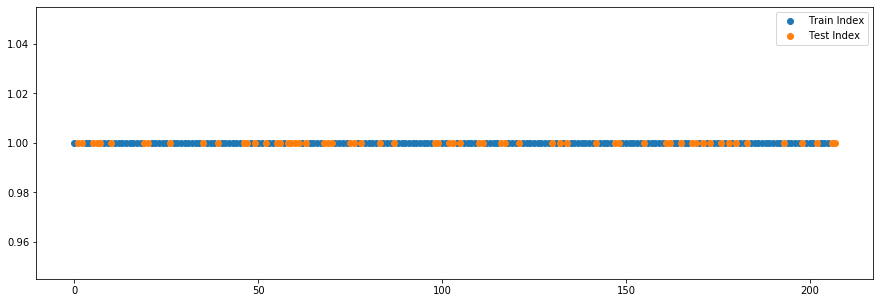

In [38]:
from sklearn.model_selection import train_test_split

index_train, index_test = train_test_split(data.index, train_size=0.7, random_state=10)

fig = plt.figure(figsize = (15, 5))
plt.plot(index_train, np.ones(len(index_train)), 'o', label='Train Index')
plt.plot(index_test, np.ones(len(index_test)), 'o', label='Test Index')

plt.legend();

In [4]:
from sklearn.model_selection import train_test_split

# Randomly split indexes
index_train, index_test = train_test_split(np.array(data.index), train_size=0.7, random_state=10)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()  # the copy here is for technical reasons

train.head()

,Gender,Experience,Salary
24,Female,11,70800
43,Female,9,59600
144,Male,7,53400
21,Female,18,68000
129,Female,15,102400


## Exploratory Data Analysis

Exploratory data analysis (EDA) is the process of discovering features and patterns in the data that should inform the modelling process and, in some cases, prevent errors. Here we conduct a short EDA of the dataset. Remember that we should use only the training set for this purpose. 

The next several cells display a range of summary measures and exploratory plots for the data. We learn for example that: 

* On average, male employees have higher salaries than female employees. The pay gap seems to be larger at the upper quantiles of the salary distribution for each group.  The variance in salaries is substantially higher for males.

 
* The distribution of salary is clearly right skewed for both males and females.


* Not surprisingly, experience is strongly positively related with salary. When considering all the employees, three of them appear to be outliers as they have much higher salaries than the rest. These are probably senior executives in the company (further investigation would reveal that they are all males). 


* There seems to be an interaction between gender and experience. The pay gap increases with the level of experience. Allowing for this interaction, the employees with highest salaries do not seem to be outliers anymore.

In [5]:
train.groupby('Gender')['Salary'].describe().round(2)  # round the results to two decimal places

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,97.0,75034.85,13573.05,54000.0,65480.0,72800.0,82800.0,123600.0
Male,48.0,90211.25,30172.77,53400.0,69130.0,85000.0,97250.0,194000.0


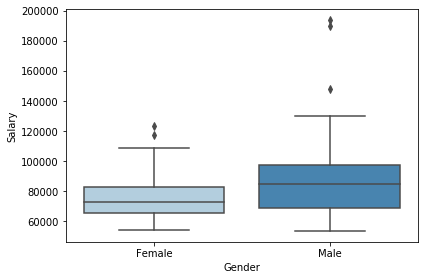

In [6]:
sns.boxplot(x='Gender', y='Salary', data=train, palette='Blues')
plt.tight_layout()
plt.show()

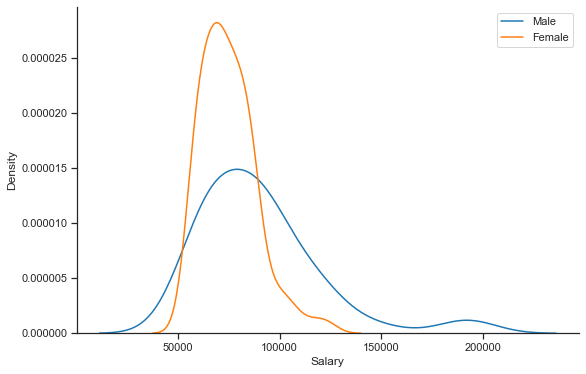

In [42]:
sns.distplot(train.loc[train['Gender']=='Male', 'Salary'], hist=False, label='Male')
sns.distplot(train.loc[train['Gender']=='Female', 'Salary'], hist=False, label='Female')
sns.despine()
plt.legend();
plt.show()

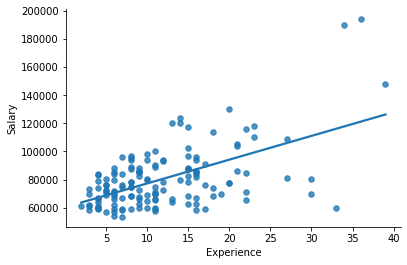

In [8]:
sns.regplot(train['Experience'], train['Salary'], scatter_kws={'s': 30}, ci=None)
sns.despine()
plt.show()

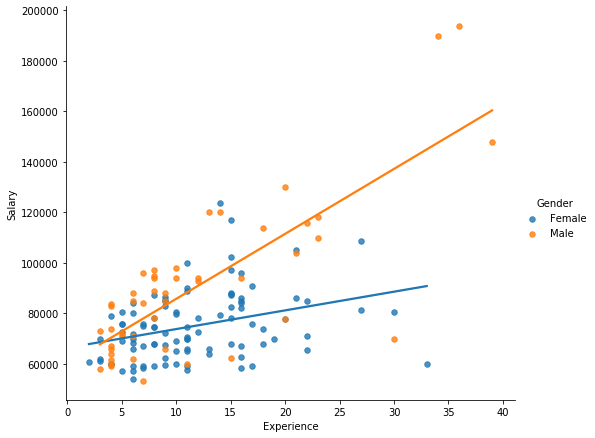

In [9]:
sns.lmplot('Experience', 'Salary', data=train, hue='Gender', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
plt.show()

## Data Preparation

In most cases, we need to perform additional processing to get the data ready for training machine learning models and computing predictions. It is good practice to write a function for this step.

Below we create a dummy valiable in order to incorporate the gender predictor into the regression.

In [10]:
train.head()

,Gender,Experience,Salary
24,Female,11,70800
43,Female,9,59600
144,Male,7,53400
21,Female,18,68000
129,Female,15,102400


In [43]:
def prepare_data(df):
    """ Given a pd.DataFrame, returns a pd.DataFrame where the 'Female' column
        is encoded as 
            1 - If 'Gender' == 'Female'
            0 - Otherwise
    
        Parameters
        ----------
        df : pd.DataFrame
            Assumed to have a column named 'Gender'
            
        Returns
        -------
        pd.DataFrame
    """
    df['Female']=(df['Gender'] =='Female').astype(int) # create dummy variable for gender (last part converts True/F to 1/0)
    return df


train = prepare_data(train)
test = prepare_data(test)

train.head()

,Gender,Experience,Salary,Female
24,Female,11,70800,1
43,Female,9,59600,1
144,Male,7,53400,0
21,Female,18,68000,1
129,Female,15,102400,1


In [44]:
prepare_data?

Creating other types of variables is easy. We know that salaries tend to increase in percentage terms every year, so that it is plausible that the relationship between salary and experience may be better described as a log-linear relationship. The log transformation may also help to reduce the positive skewness that we found in the EDA. 

## Linear Regression

There are several ways to estimate a linear regresssion in Python. In this tutorial, we use the statmodels package, as it generates [more informative](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.html) outputs and results.

In [12]:
import statsmodels.formula.api as smf

formula='Salary ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     52.64
Date:                Sat, 13 Mar 2021   Prob (F-statistic):           7.86e-18
Time:                        09:29:58   Log-Likelihood:                -1612.9
No. Observations:                 145   AIC:                             3232.
Df Residuals:                     142   BIC:                             3241.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    7.04e+04   3275.348     21.494      0.0

The output is difficult to read because of the scale of the salary variable.  We can improve it by expressing the salary in thousands.  Using the formula approach makes it easier to transform variables for purposes of estimating the regression. 

In [13]:
formula='np.divide(Salary, 1000) ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

                               OLS Regression Results                              
Dep. Variable:     np.divide(Salary, 1000)   R-squared:                       0.426
Model:                                 OLS   Adj. R-squared:                  0.418
Method:                      Least Squares   F-statistic:                     52.64
Date:                     Sat, 13 Mar 2021   Prob (F-statistic):           7.86e-18
Time:                             09:30:00   Log-Likelihood:                -611.30
No. Observations:                      145   AIC:                             1229.
Df Residuals:                          142   BIC:                             1238.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
In

If were compare a male and female employee with the same level of experience, we would expect the female employee to earn 15.1K less according to this estimate (note: coefficients depend on the random split into training and test data, so you might get different values). The coefficient for the Female variable is statistically significant, so that we can reliably conclude that the female employees have lower salaries on average controlling for experience. 

Is this model appropriate for the data? We should use residual diagnostics to check. The diagnostic plot below reveals a nonlinear pattern in the residuals, which means that the linear specification is not correct for this data. We should try to improve the model by considering a log transformation (suggested by domain knowledge and EDA) and an interaction term (suggested by EDA). 

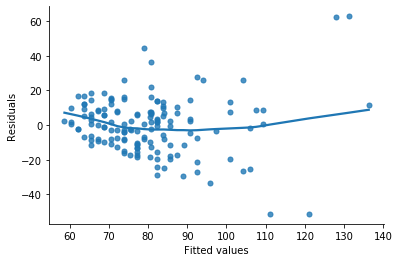

In [14]:
fig, ax= plt.subplots()

# Note that we are getting the fitted values and the residuals from the regression results here
# The lowess option fits a nonparametric regression to the scatter plot, allowing us to visualise possible nonlinear patterns

sns.regplot(ols.fittedvalues, ols.resid, scatter_kws={'s' : 25}, lowess=True, ax=ax) 
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted values')
sns.despine()
plt.show()

Interpret the two models below (especially the coefficients). Note that the second model includes a an interaction term (for gender and experience).

In [15]:
formula='np.log(Salary) ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:         np.log(Salary)   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     42.90
Date:                Sat, 13 Mar 2021   Prob (F-statistic):           2.67e-15
Time:                        09:30:07   Log-Likelihood:                 41.754
No. Observations:                 145   AIC:                            -77.51
Df Residuals:                     142   BIC:                            -68.58
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1676      0.036    308.103      0.0

In [16]:
formula='np.log(Salary) ~ Female + Experience + Experience:Female'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:         np.log(Salary)   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     35.06
Date:                Sat, 13 Mar 2021   Prob (F-statistic):           5.42e-17
Time:                        09:30:08   Log-Likelihood:                 47.894
No. Observations:                 145   AIC:                            -87.79
Df Residuals:                     141   BIC:                            -75.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.0863      0.04

We can check that this last specification improves the residuals.

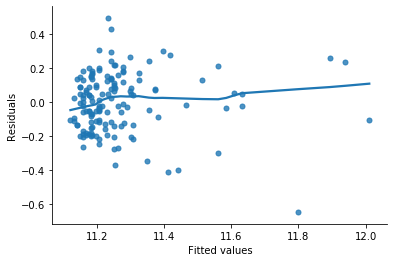

In [17]:
fig, ax= plt.subplots()
sns.regplot(ols.fittedvalues, ols.resid, scatter_kws={'s': 25}, lowess=True, ax=ax)
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted values')
sns.despine()
plt.show()






## Model Evaluation

We now compare different specifications on the test data. Note that for the models with a log transformed response, we use an appropriate retransformation and an adjustment when computing the predictions for salary. 

We should be careful with our analysis since there are not many test cases. Here are some tentative conclusions. 

* The models with an interaction term predict better than the ones without.


* When comparing the two models with the interaction term, the log model has slightly better predictive ability.

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rmse=[]       # initialize the rmse list
r2=[]         # initialize the r-squared list

# Model 1
formula='Salary ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()       # run the ols model
predictions = ols.predict(test)       # use the model to make predictions on the test data 
rmse.append(np.sqrt(mean_squared_error(test['Salary'], predictions)))  # evaluate the rmse and add it to the rmse list
r2.append(r2_score(test['Salary'], predictions))                   # evaluate the r-squared and add it to the r-squared list

# Model 2
formula='Salary ~ Female + Experience + Experience:Female'
ols = smf.ols(formula=formula, data=train).fit()
predictions = ols.predict(test)
rmse.append(np.sqrt(mean_squared_error(test['Salary'], predictions)))
r2.append(r2_score(test['Salary'], predictions))

# Model 3
formula='np.log(Salary) ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
predictions = np.exp(ols.predict(test))*np.mean(np.exp(ols.resid))
rmse.append(np.sqrt(mean_squared_error(test['Salary'], predictions)))
r2.append(r2_score(test['Salary'], predictions))

# Model 4
formula='np.log(Salary) ~ Female + Experience + Experience:Female'
ols= smf.ols(formula=formula, data=train).fit()
predictions = np.exp(ols.predict(test))*np.mean(np.exp(ols.resid))
rmse.append(np.sqrt(mean_squared_error(test['Salary'], predictions)))
r2.append(r2_score(test['Salary'], predictions))


# Initialise the table that will display the results
columns=['RMSE', 'R-Squared']
rows=['Base Model',  'Interaction', 'Log Transform', 'Log Transform + Interaction']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# Fill out the table
for i in range(4):
    results.iloc[i, 0] = rmse[i]
    results.iloc[i, 1] = r2[i]
    
results.round(2)

,RMSE,R-Squared
Base Model,17795.96,0.46
Interaction,15052.05,0.61
Log Transform,17337.79,0.49
Log Transform + Interaction,14851.05,0.62
